# Data Exploration

Load and prepare the E2 dataset for anomaly detection.


In [13]:
import pandas as pd
import numpy as np
import gzip
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


## Configuration


In [5]:
DATASET_PATH = "../e2-master"
SCENARIO = "pandex"
PROVIDER = "trace"

BASE_PATH = Path(DATASET_PATH) / SCENARIO / PROVIDER
BASE_PATH = Path(DATASET_PATH) / SCENARIO / PROVIDER
print(f"Dataset: {SCENARIO}/{PROVIDER}")
print(f"Path: {BASE_PATH}")


Dataset: pandex/trace
Path: ../e2-master/pandex/trace


## Load ProcessAll.csv.gz Data


In [6]:
process_file = BASE_PATH / "ProcessAll.csv.gz"

with gzip.open(process_file, 'rt') as f:
    df_process = pd.read_csv(f)

print(f"Shape: {df_process.shape}")
print(f"Columns: {len(df_process.columns)}")
df_process.head()


Shape: (272376, 300)
Columns: 300


,UUID,X0_EVENT_ACCEPT,X0_EVENT_CHANGE_PRINCIPAL,X0_EVENT_CLONE,X0_EVENT_CLOSE,X0_EVENT_CONNECT,X0_EVENT_CREATE_OBJECT,X0_EVENT_EXECUTE,X0_EVENT_EXIT,X0_EVENT_FORK,...,X3_72.9.238.178,X3_205.217.32.211,X3_216.38.163.117,X3_::0000:0.0.0.1,X3_201.52.123.80,X3_198.151.60.58,X3_65.182.162.233,X3_213.206.123.35,X3_216.39.86.61,X3_128.55.12.167
0,a9260ed7-72b0-36d0-9619-932edc576805,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,5f5f16c3-6727-3b57-9367-ccd7c24a4ecb,0,0,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,11ce45cb-dc03-3623-8113-76e8f4d511e2,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,a109d1cc-b825-3c05-91a0-d439171ad3fe,0,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,f77fa6ca-9052-3a02-a334-d7652c002d5c,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Category Analysis

In [26]:
# Analyze feature columns
id_col = df_process.columns[0]
feature_cols = [col for col in df_process.columns if col != id_col]

# Group features by prefix
feature_categories = {'X0_': [], 'X1_': [], 'X2_': [], 'X3_': [], 'Other': []}

for col in feature_cols:
    categorized = False
    for prefix in ['X0_', 'X1_', 'X2_', 'X3_']:
        if col.startswith(prefix):
            feature_categories[prefix].append(col)
            categorized = True
            break
    if not categorized:
        feature_categories['Other'].append(col)

print("📊 Feature Categories:")
print("="*60)
for category, cols in feature_categories.items():
    print(f"{category:8s}: {len(cols):4d} features")
    if 0 < len(cols) <= 10:
        print(f"           {cols}")
    elif len(cols) > 10:
        print(f"           First 5: {cols[:5]}")
        print(f"           Last 5:  {cols[-5:]}")
print("="*60)
print(f"Total: {len(feature_cols)} features")

📊 Feature Categories:
X0_     :   24 features
           First 5: ['X0_EVENT_ACCEPT', 'X0_EVENT_CHANGE_PRINCIPAL', 'X0_EVENT_CLONE', 'X0_EVENT_CLOSE', 'X0_EVENT_CONNECT']
           Last 5:  ['X0_EVENT_TRUNCATE', 'X0_EVENT_UNIT', 'X0_EVENT_UNLINK', 'X0_EVENT_UPDATE', 'X0_EVENT_WRITE']
X1_     :  154 features
           First 5: ['X1_insmod', 'X1_zenity', 'X1_/usr/bin/perl', 'X1_/usr/bin/pulseaudio', 'X1_sudo']
           Last 5:  ['X1_/bin/plymouth', 'X1_chmod', 'X1_reload', 'X1_/usr/local/firefox-42.0/firefox-build/dist/bin/plugin-container', 'X1_gzip']
X2_     :   40 features
           First 5: ['X2_/usr/sbin/logrotate', 'X2_su', 'X2_nexus', 'X2_sudo', 'X2_/sbin/shutdown']
           Last 5:  ['X2_run-parts', 'X2_/home/steve/nexus', 'X2_vim', 'X2_[Record', 'X2_env']
X3_     :   81 features
           First 5: ['X3_216.73.87.152', 'X3_193.95.68.152', 'X3_200.200.200.10', 'X3_208.65.153.253', 'X3_6000']
           Last 5:  ['X3_198.151.60.58', 'X3_65.182.162.233', 'X3_213.206.123.35',

## Feature Sparsity


*** Feature Statistics:
Total features:      299
Active features:     299
Dead features:       0
Overall sparsity:    98.0%

*** Sparsity by Category:
   X0_     : 80.6% sparsity, 24/24 active
   X1_     : 99.6% sparsity, 154/154 active
   X2_     : 98.1% sparsity, 40/40 active
   X3_     : 100.0% sparsity, 81/81 active

*** Per-Process Activity:
   Mean features per process: 6.12
   Std features per process:  3.79
   Min features per process:  1
   Max features per process:  70


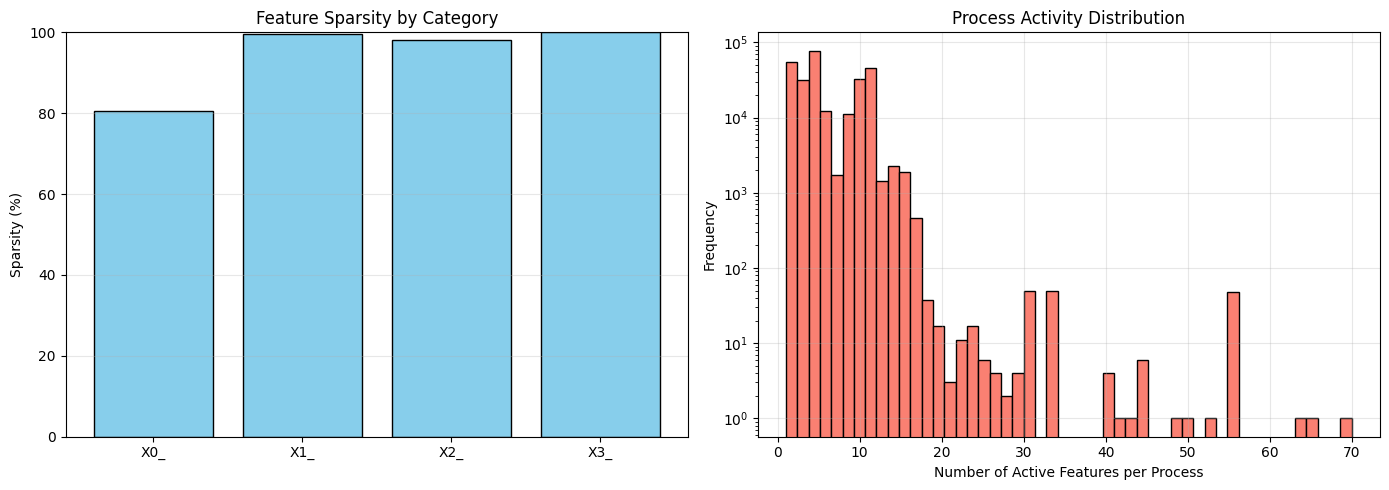

In [28]:
# Extract feature matrix
X = df_process[feature_cols].values.astype(np.float32)

# Calculate statistics
feature_sums = X.sum(axis=0)
sparsity = (X == 0).mean()

print(f"\n*** Feature Statistics:")
print(f"="*60)
print(f"Total features:      {X.shape[1]:,}")
print(f"Active features:     {(feature_sums > 0).sum():,}")
print(f"Dead features:       {(feature_sums == 0).sum():,}")
print(f"Overall sparsity:    {sparsity:.1%}")
print(f"="*60)

# Sparsity by category
print(f"\n*** Sparsity by Category:")
for category, cols in feature_categories.items():
    if len(cols) > 0:
        cat_indices = [feature_cols.index(col) for col in cols]
        cat_sparsity = (X[:, cat_indices] == 0).mean()
        cat_active = (X[:, cat_indices].sum(axis=0) > 0).sum()
        print(f"   {category:8s}: {cat_sparsity:.1%} sparsity, {cat_active}/{len(cols)} active")

# Per-sample activity
sample_activity = X.sum(axis=1)
print(f"\n*** Per-Process Activity:")
print(f"   Mean features per process: {sample_activity.mean():.2f}")
print(f"   Std features per process:  {sample_activity.std():.2f}")
print(f"   Min features per process:  {sample_activity.min():.0f}")
print(f"   Max features per process:  {sample_activity.max():.0f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sparsity by category
categories = [k for k, v in feature_categories.items() if len(v) > 0]
sparsities = []
for cat in categories:
    cols = feature_categories[cat]
    cat_indices = [feature_cols.index(col) for col in cols]
    cat_sparsity = (X[:, cat_indices] == 0).mean() * 100
    sparsities.append(cat_sparsity)

axes[0].bar(categories, sparsities, color='skyblue', edgecolor='black')
axes[0].set_ylabel('Sparsity (%)')
axes[0].set_title('Feature Sparsity by Category')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 100])

# Activity distribution
axes[1].hist(sample_activity, bins=50, color='salmon', edgecolor='black')
axes[1].set_xlabel('Number of Active Features per Process')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Process Activity Distribution')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Load Ground Truth Labels


In [17]:
attack_uuids = set()
gt_files = list(BASE_PATH.glob(f"{PROVIDER}_{SCENARIO}_*.csv"))

for gt_file in gt_files:
    gt_df = pd.read_csv(gt_file)
    if 'uuid' in gt_df.columns:
        uuids = set(gt_df['uuid'].unique())
        attack_uuids.update(uuids)
        print(f"{gt_file.name}: {len(uuids)} attacks")

print(f"\nTotal attack processes: {len(attack_uuids)}")
print(f"Total processes: {len(df_process)}")
print(f"Attack ratio: {len(attack_uuids) / len(df_process):.2%}")


trace_pandex_micro.csv: 82 attacks
trace_pandex_drakon2.csv: 25 attacks
trace_pandex_drakon.csv: 47 attacks

Total attack processes: 153
Total processes: 272376
Attack ratio: 0.06%


## Extract Features and Labels


In [18]:
id_col = df_process.columns[0]
feature_cols = [col for col in df_process.columns if col != id_col]

X = df_process[feature_cols].values.astype(np.float32)
process_uuids = df_process[id_col].values
y = np.array([1 if uuid in attack_uuids else 0 for uuid in process_uuids])

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Positive samples: {y.sum()} ({y.mean():.2%})")


Features shape: (272376, 299)
Labels shape: (272376,)
Positive samples: 25 (0.01%)


## Top Distinguishing Features



*** Data Split:
Normal processes: 272,351 (100.0%)
Attack processes: 25 (0.0%)

*** Top 15 Distinguishing Features:
#   Feature                                           Normal     Attack       Diff
1   X3_80                                              0.001      0.760     +0.759
2   X0_EVENT_SENDMSG                                   0.016      0.640     +0.624
3   X0_EVENT_CONNECT                                   0.028      0.480     +0.452
4   X1_firefox                                         0.071      0.480     +0.409
5   X3_215.25.80.123                                   0.000      0.400     +0.400
6   X2_firefox                                         0.183      0.480     +0.297
7   X1_nexus                                           0.000      0.280     +0.280
8   X0_EVENT_OPEN                                      0.384      0.640     +0.256
9   X0_EVENT_CLONE                                     0.186      0.440     +0.254
10  X0_EVENT_RECVMSG                                 

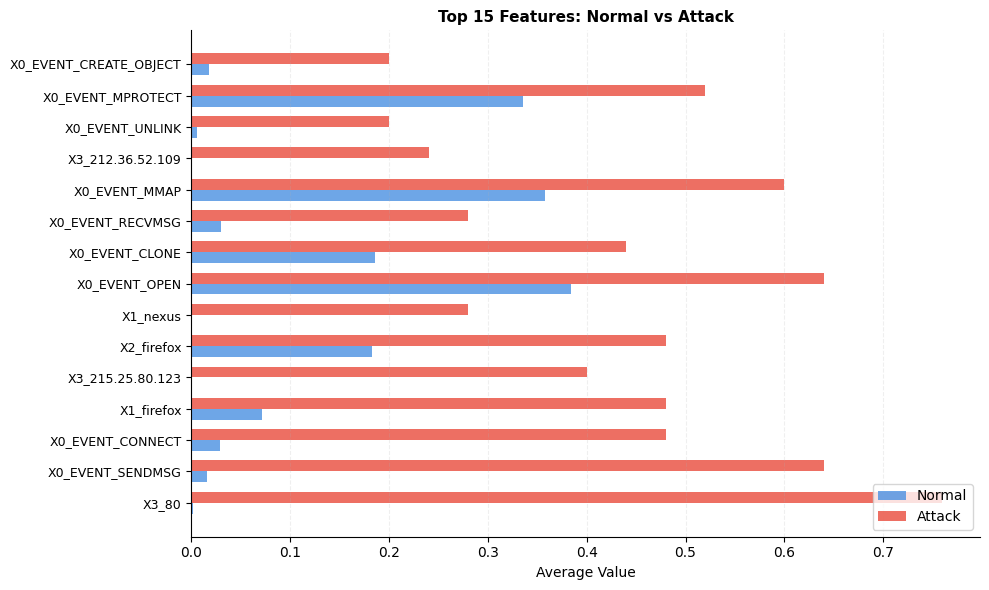

In [31]:
# (Normal vs Attack)

# Create labels
process_uuids = df_process[id_col].values
labels = np.array([1 if uuid in attack_uuids else 0 for uuid in process_uuids])

# Split data by label
X_normal = X[labels == 0]
X_attack = X[labels == 1]

print(f"\n*** Data Split:")
print(f"="*60)
print(f"Normal processes: {len(X_normal):,} ({len(X_normal)/len(X):.1%})")
print(f"Attack processes: {len(X_attack):,} ({len(X_attack)/len(X):.1%})")
print(f"="*60)

if len(X_attack) > 0:
    # Calculate average feature values for normal vs attack
    normal_avg = X_normal.mean(axis=0)
    attack_avg = X_attack.mean(axis=0)
    
    # Find features with biggest differences
    feature_diff = np.abs(attack_avg - normal_avg)
    top_diff_idx = np.argsort(feature_diff)[-15:][::-1]  # Top 15, descending
    
    top_diff_features = [feature_cols[i] for i in top_diff_idx]
    top_diff_normal = normal_avg[top_diff_idx]
    top_diff_attack = attack_avg[top_diff_idx]
    
    print(f"\n*** Top 15 Distinguishing Features:")
    print(f"="*80)
    print(f"{'#':<3} {'Feature':<45} {'Normal':>10} {'Attack':>10} {'Diff':>10}")
    print(f"="*80)
    for i, (feat, norm_val, att_val) in enumerate(zip(top_diff_features, top_diff_normal, top_diff_attack), 1):
        diff = att_val - norm_val
        print(f"{i:<3} {feat[:45]:<45} {norm_val:>10.3f} {att_val:>10.3f} {diff:>+10.3f}")
    print(f"="*80)
    
    # Minimal plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_pos = np.arange(len(top_diff_features))
    width = 0.35
    
    ax.barh(x_pos - width/2, top_diff_normal, width, label='Normal', color='#4A90E2', alpha=0.8)
    ax.barh(x_pos + width/2, top_diff_attack, width, label='Attack', color='#E94B3C', alpha=0.8)
    
    ax.set_yticks(x_pos)
    ax.set_yticklabels([f[:35] for f in top_diff_features], fontsize=9)
    ax.set_xlabel('Average Value', fontsize=10)
    ax.set_title('Top 15 Features: Normal vs Attack', fontsize=11, fontweight='bold')
    ax.legend(loc='lower right', frameon=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='x', alpha=0.2, linestyle='--')
    
    plt.tight_layout()
    plt.show()

## Key observations:
- Highly sparse feature space
- Imbalanced dataset with few attack samples
